In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import os
from scipy.stats import pearsonr, spearmanr, fisher_exact, mannwhitneyu, ttest_ind

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

from matplotlib.pyplot import rc_context
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
sys.path.append('../../Code/')
from utils import read_dataset_log
import pickle as pkl
import matplotlib.gridspec as gridspec

In [2]:
from matplotlib import rcParams, font_manager
import matplotlib


rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
label_fontsize = 10
tick_fontsize = 8

In [3]:
figdir = '../../Figures/Components'

In [34]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom diverging colormap
custom_cmap = LinearSegmentedColormap.from_list("CustomMap", ["steelblue", "snow", "salmon"])


In [36]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,scores_fn,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,...,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label,tcat_fn_old
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,...,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,...,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,...,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,...,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,...,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Activ...,...,

In [37]:
gep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(gep_info['cGep_Name'], gep_info['Short_Name']))

In [38]:
geps = ['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated']


In [39]:
gep_paths = read_dataset_log('cGEP Paths')
Z_spec = pd.read_csv(gep_paths['scores_spectra'][0], index_col = 0, sep = '\t')
Z_spec.index = Z_spec.index.map(rename_map)

In [40]:
top_markers = {}
marker_genes = []
for g in geps:
    marker_genes += list(Z_spec.loc[g, :].sort_values(ascending = False).head(50).index)
    top_markers[g] = list(Z_spec.loc[g, :].sort_values(ascending = False).head(50).index)
    
marker_genes += ['TBX21', 'FOXP3', 'GATA3', 'RORC', 'CCR4', 'CCR6', 'CXCR3', 
                'AHR', 'IL4', 'IL5', 'IL13', 'IL17A', 'IL17F', 'IFNG']

marker_genes = sorted(set(marker_genes))

In [41]:
marker_adts = ['AB_CD194', 'AB_CD195', 'AB_CD4', 'AB_CD8']

# Sparks

In [ ]:
summary = []
for dataset in ['Sparks']: #, 'Sparks', 'UK-Covid', ' AMP-RA']:
    usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage.columns = usage.columns.map(rename_map)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    X = usage_norm[['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated',
                   'Cytotoxic']]
    X['Dataset'] = dataset
    gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
    X['gating'] = gating.loc[X.index]
    expr_fn = params.loc[dataset, 'raw_counts_filt_fn']
    adata = sc.read(expr_fn)
    adata_RNA = adata[:, adata.var['feature_types'] == 'Gene Expression']
    adata_ADT = adata[:, adata.var['feature_types'] == 'Antibody Capture']
    meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')
    
    ind = sorted(set(X.index).intersection(adata.obs.index))
    X = X.loc[ind, :]
    
    X['individual'] = adata_RNA.obs.loc[X.index, params.loc[dataset, 'individual_col']]
    X['sample'] = meta.loc[X.index, params.loc[dataset, 'sample_col']]
    # X['sample'] = adata.obs.loc[X.index, params.loc[dataset, 'sample_col']]    
    X['N'] = np.array(adata_RNA[X.index, :].X.sum(axis=1)).reshape(-1)
    
    marker_genes_filt = sorted(set(marker_genes).intersection(adata.var.index))
    print(sorted(set(marker_genes).difference(adata.var.index)))
    X[marker_genes_filt] = adata[ind, marker_genes_filt].X.todense()
    
    X['N_ADT'] = np.array(adata_ADT[X.index, :].X.sum(axis=1)).reshape(-1)
    X[marker_adts] = adata_ADT[ind, marker_adts].X.todense()

In [54]:
meta[params.loc[dataset, 'individual_col']].value_counts()

COVR-31    13517
Control    13478
HC-18      11862
COVR-29    11716
COVR-23    11340
COVR-25    11118
COVR-2     10809
HC-22      10544
COVR-12     9405
HC-28       9377
COVR-24     9203
HC-31       8991
HC-16       8958
HC-37       8877
COVR-13     8860
HC-38       8521
COVR-8      8496
COVR-21     8460
COVR-18     8259
COVR-33     8256
COVR-9      8210
COVR-26     7918
HC-7        7846
HC-40       7842
HC-20       7818
COVR-4      7707
COVR-22     7545
HC-35       7016
COVR-20     6980
HC-27       6653
HC-21       6566
COVR-28     6497
HC-12       6434
COVR-10     6286
HC-15       6206
COVR-27     6125
HC-34       5278
COVR-16     5194
COVR-15     5006
COVR-14     4348
COVR-6      3217
Name: alt.subject.id, dtype: int64

In [53]:
meta[params.loc[dataset, 'sample_col']].value_counts()

Control        13478
COVR-31.D0      5760
COVR-23.D28     5485
COVR-31.D1      5417
HC-18.D1        4928
               ...  
COVR-28.D28     1285
COVR-10.D28     1283
COVR-16.D1      1213
COVR-6.D0       1146
COVR-6.D28       719
Name: alt.sample.id, Length: 121, dtype: int64

In [ ]:
thresh = 0.1#0.0625

for g in geps:
    X['Bin_%s' % g] = X[g]>thresh

In [553]:
cd4_gates = ['CD4_Naive', 'Treg', 'CD4_EM', 'CD4_CM', 'CD4_TEMRA']
cd8_gates = ['CD8_Naive', 'CD8_EM', 'CD8_CM', 'CD8_TEMRA']

X['class'] = 'Other'
X.loc[X['gating'].isin(cd4_gates), 'class'] = 'CD4'
X.loc[X['gating'].isin(cd8_gates), 'class'] = 'CD8'

## Genes per cGEP

### All, Th1 with and without cytotoxic

In [557]:
sample_order = list(X['sample'].unique())
len(sample_order)

121

In [558]:
X_test = X #X[(X['Cytotoxic'] <= thresh)]

In [559]:
X_test_nocyto = X[(X['Cytotoxic'] <= thresh)]

In [560]:
gep_list = ['Th2-Resting', 'Th17-Resting', 'Th1-Like (Cytotoxic Unfilt.)', 'Th1-Like (Cytotoxic Filt.)']

In [561]:
ms_rna_dict = {'Th1-Like' : ['CXCR3','IFNG-AS1', 'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              'Th2-Activated' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Activated' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194']}

In [815]:
gep_list

['Th2-Resting',
 'Th17-Resting',
 'Th1-Like (Cytotoxic Unfilt.)',
 'Th1-Like (Cytotoxic Filt.)']

In [ ]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []

for gname in gep_list:
    
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname
        
    if gname=='Th1-Like (Cytotoxic Filt.)':
        sample_sum = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']

    else:
        sample_sum = X_test.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = ms_rna_dict[g]
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
    
    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[gname] = dat_all
    ms_all += ms

In [ ]:
vmax_list = []
# Get vmax using normalized dat and markers
for gname in gep_list:
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname

    dat_all = gep_dat[gname]    
    ms = []
    ms_rna = ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.99)
vmin = -vmax

In [818]:
vmax

2.5054773235321015

In [819]:
tick_fontsize, label_fontsize

(8, 10)

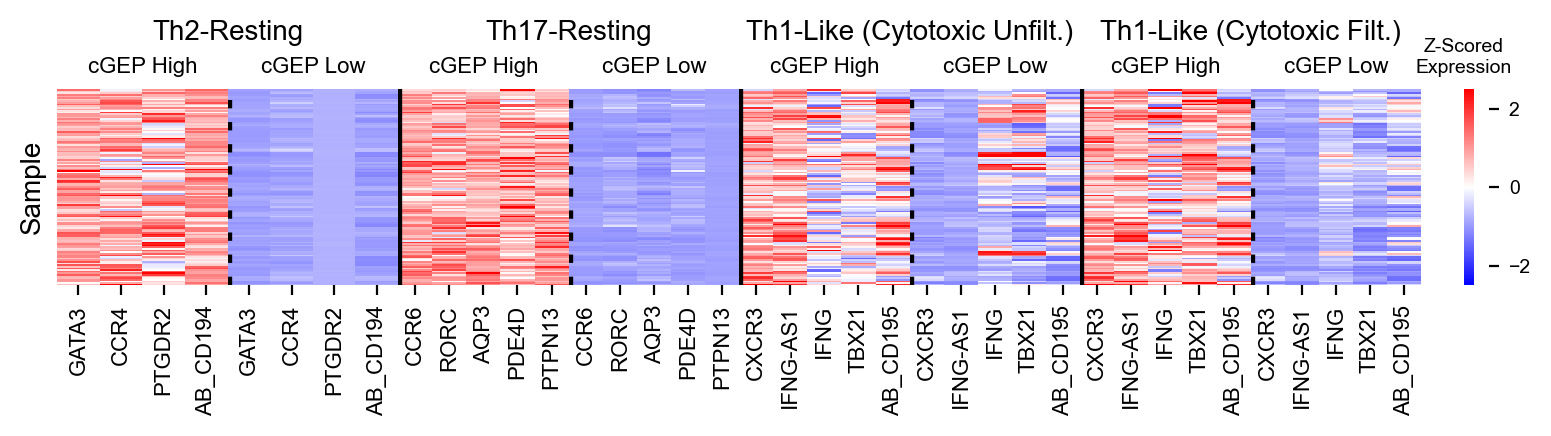

In [827]:
nrows = 1
ncols = 2*len(gep_list)
width = 2.2*len(gep_list)
height = 1.3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0})

for j, gname in enumerate(gep_list):
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname
    
    # High/Low polarizations
    for i, b in enumerate([True, False]):
        ax = axes[2*j + i]
        dat_all = gep_dat[gname]
        dat = dat_all[dat_all['Bin_%s' % g]==b]
        dat.index = dat['sample']
        
        ms = []
        ms_rna = ms_rna_dict[g]
        ms += ms_rna
        if g in ms_adt_dict.keys():
            ms_adt = ms_adt_dict[g]
            ms += ms_adt

        sns.heatmap(dat.loc[sample_order, ms], cmap = 'bwr', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
        ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
        if i == 0:
            ax.text(1, 1.25, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

        ax.set_yticks([])
        ax.set_xticks(np.arange(0.5, len(ms)), ms)
        ax.tick_params('x', labelsize = tick_fontsize)

        if (j==0) & (i==0):
            ax.set_ylabel('Sample', fontsize = label_fontsize)
            # ax.collections[0].colorbar.remove()
            
        elif i==0:
            ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 3)

        else:
            ax.axvline(0, 0, dat.shape[0], color = 'black', linestyle = 'dotted', linewidth = 3)

cax = ax.inset_axes([1.1, 0, .3, 1], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("bwr", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1)

# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.Sparks.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.Sparks.pdf'), bbox_inches="tight")

In [965]:
list(Z_spec.loc['Th17-Resting', :].sort_values(ascending = False).index).index('GATA3')

1082

In [957]:
Z_spec['GATA3'].sort_values(ascending = False)

Th2-Activated          0.008509
Th2-Resting            0.008107
RGCC/MYADM             0.003189
Th22                   0.000831
Treg                   0.000769
CD40LG/TXNIP           0.000666
Poor-Quality           0.000546
IEG2                   0.000506
ICOS/CD38              0.000460
Th17-Resting           0.000343
ISG                    0.000314
HLA                    0.000288
Th1-Like               0.000218
CD8-Trm                0.000198
TIMD4/TIM3             0.000169
OX40/EBI3              0.000147
TEMRA                  0.000088
IL10/IL19              0.000063
CellCycle-G2M          0.000046
Tfh-2                  0.000033
MAIT                   0.000022
SOX4/TOX2             -0.000038
IEG                   -0.000094
Tph                   -0.000097
CellCycle-Late-S      -0.000112
CellCycle-S           -0.000115
Multi-Cytokine        -0.000119
Mito                  -0.000131
NME1/FABP5            -0.000132
gdT                   -0.000166
Doublet-Bcell         -0.000187
Heatshoc

#### Th1 GEP only

In [563]:
sample_order = list(X['sample'].unique())
len(sample_order)

121

In [564]:
X_test = X #X[(X['Cytotoxic'] <= thresh)]

In [565]:
X_test_nocyto = X[(X['Cytotoxic'] <= thresh)]

In [566]:
gep_list = [#'Th2-Resting', 'Th17-Resting', 
            'Th1-Like (Cytotoxic Unfilt.)', 'Th1-Like (Cytotoxic Filt.)']

In [567]:
ms_rna_dict = {'Th1-Like' : ['CXCR3','IFNG-AS1', 'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              'Th2-Activated' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Activated' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194']}

In [1078]:
gep_list

['Th1-Like (Cytotoxic Unfilt.)', 'Th1-Like (Cytotoxic Filt.)']

In [570]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []

for gname in gep_list:
    
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname
        
    if gname=='Th1-Like (Cytotoxic Filt.)':
        sample_sum = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']

    else:
        sample_sum = X_test.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = ms_rna_dict[g]
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
    
    # sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[gname] = dat_all
    ms_all += ms

In [571]:
vmax_list = []
# Get vmax using normalized dat and markers
for gname in gep_list:
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname

    dat_all = gep_dat[gname]    
    ms = []
    ms_rna = ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.99)
vmin = -vmax

In [572]:
vmax

2.7050267839431745

In [573]:
tick_fontsize, label_fontsize

(8, 10)

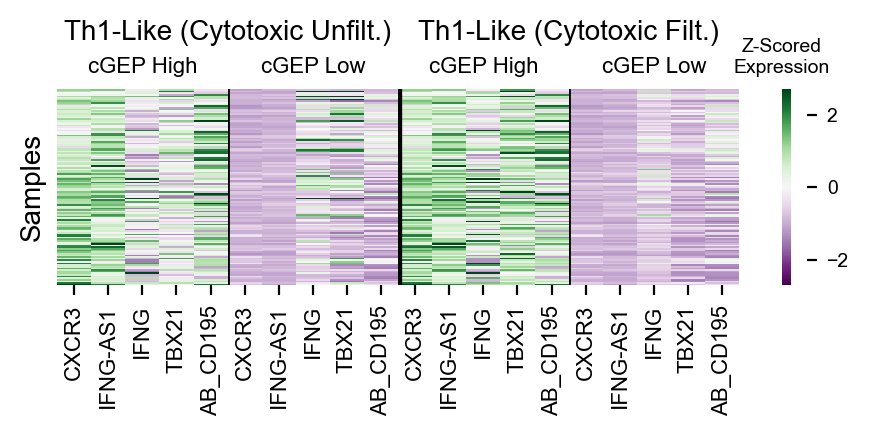

In [1085]:
nrows = 1
ncols = 2*len(gep_list)
width = 2.2*len(gep_list)
height = 1.3
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0})

for j, gname in enumerate(gep_list):
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname
    
    # High/Low polarizations
    for i, b in enumerate([True, False]):
        ax = axes[2*j + i]
        dat_all = gep_dat[gname]
        dat = dat_all[dat_all['Bin_%s' % g]==b]
        dat.index = dat['sample']
        
        ms = []
        ms_rna = ms_rna_dict[g]
        ms += ms_rna
        if g in ms_adt_dict.keys():
            ms_adt = ms_adt_dict[g]
            ms += ms_adt

        sns.heatmap(dat.loc[sample_order, ms], cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
        ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
        if i == 0:
            ax.text(1, 1.25, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

        ax.set_yticks([])
        ax.set_xticks(np.arange(0.5, len(ms)), ms)
        ax.tick_params('x', labelsize = tick_fontsize)
        ax.set_ylabel('', fontsize = label_fontsize)

        if (j==0) & (i==0):
            ax.set_ylabel('Samples', fontsize = label_fontsize)
            # ax.collections[0].colorbar.remove()
            
        elif i==0:
            ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 3)

        else:
            ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)

cax = ax.inset_axes([1.1, 0, .3, 1], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1)

plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.Sparks.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.Sparks.pdf'), bbox_inches="tight")

## All genes

### All, exclude cytotoxic only for Th1

In [583]:
X_test = X #X[(X['Cytotoxic'] <= thresh)]

In [584]:
X_test_nocyto = X[(X['Cytotoxic'] <= thresh)]

In [586]:
ms_rna_dict = {'Th1-Like' : ['CXCR3','IFNG-AS1', 'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              'Th2-Activated' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Activated' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194']}

In [587]:
gep_list = ['Th2-Resting',
 'Th17-Resting',
 'Th1-Like']

In [588]:
ms_all = []
ms_rna_all = []
ms_adt_all = []

for g in gep_list:
    print(g)
    
    ms_rna = ms_rna_dict[g]
    ms_rna_all += ms_rna
    ms_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms_adt_all += ms_adt
        ms_all += ms_adt


Th2-Resting
Th17-Resting
Th1-Like


In [592]:
sample_order = list(X['sample'].unique())
len(sample_order)

121

In [598]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}

for g in gep_list:

    if g=='Th1-Like':
        sample_sum = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']

    else:
        sample_sum = X_test.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']

        
    # ms = []
    # ms_rna = ms_rna_dict[g]
    ms_rna = ms_rna_all
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    # ms += ms_rna
    
    # if g in ms_adt_dict.keys():
    #     ms_adt = ms_adt_dict[g]
    ms_adt = ms_adt_all
    pseudobulk_adt = sample_sum[ms_adt] #+1
    pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
    sample_sum[ms_adt] = pseudobulk_adt
    ms = ms_rna + ms_adt
    
    # sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    # dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    # dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[g] = dat_all


In [ ]:
# Row normalize using all

In [599]:
all_gep_dat = pd.DataFrame()
for g in gep_list:
    print(g)
    all_gep_dat = all_gep_dat.append(gep_dat[g][ms_all])

means = all_gep_dat[ms].mean()
stds = all_gep_dat[ms].std()

for g in gep_list:
    gep_dat[g][ms] = gep_dat[g][ms].subtract(means, axis =1)
    gep_dat[g][ms] = gep_dat[g][ms].divide(stds, axis = 1)

Th2-Resting
Th17-Resting
Th1-Like


In [600]:
gep_dat.keys()

dict_keys(['Th2-Resting', 'Th17-Resting', 'Th1-Like'])

In [601]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    # if 'Th1-Like' in gname:
    #     g = 'Th1-Like'
    # else:
    #     g = gname

    dat_all = gep_dat[g]        
    vmax_list += dat_all[ms_all].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.99)
vmin = -vmax

In [602]:
vmax

3.2883464479446456

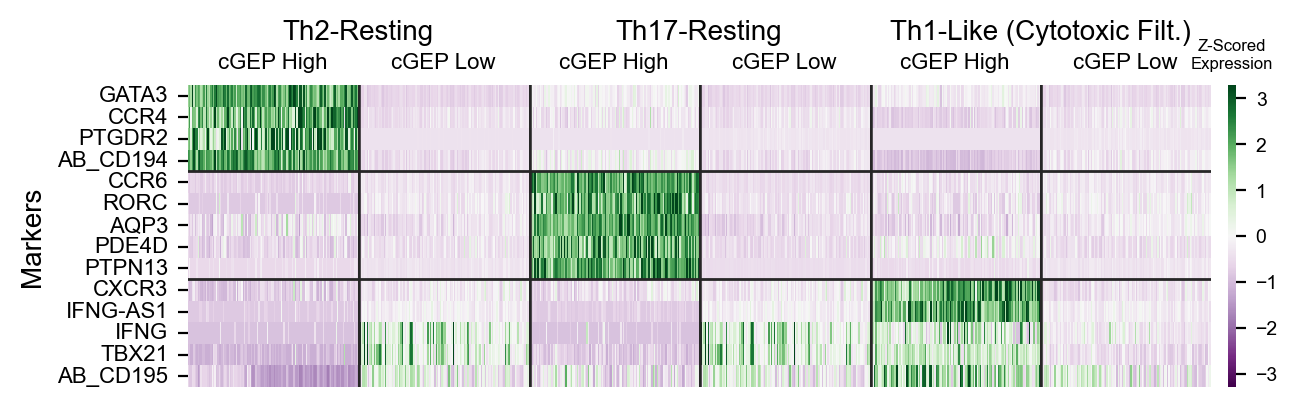

In [614]:
nrows = 1
ncols = 2*len(gep_list)
width = 2.2*len(gep_list)
height = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0})

for j, g in enumerate(gep_list):
    # High/Low polarizations
    for i, b in enumerate([True, False]):
        ax = axes[2*j + i]
        dat_all = gep_dat[g]
        dat = dat_all[dat_all['Bin_%s' % g]==b]
        dat.index = dat['sample']
        
        sns.heatmap(dat.loc[sample_order, ms_all].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
        ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
        if i == 0:
            if g != 'Th1-Like':
                gname = g
            else:
                gname = 'Th1-Like (Cytotoxic Filt.)'
            ax.text(1, 1.15, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

        ax.set_yticks([])
        ax.set_xticks([])
        # ax.set_xticks(np.arange(0.5, len(ms)), ms)
        ax.tick_params('y', labelsize = tick_fontsize)
        ax.set_xlabel('')

        if (j==0) & (i==0):
            ax.set_ylabel('Markers', fontsize = label_fontsize)
            ax.set_yticks(np.arange(0.5, len(ms_all)), ms_all)
            # ax.collections[0].colorbar.remove()
            
        elif i==0:
            ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)

        else:
            ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)
            
        ax.axhline(4, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(9, 0, 10, color = '#262626', linewidth = 1)
        

cax = ax.inset_axes([1.1, 0, .05, 1], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
# cax.set_xticks([vmin, vmax])
# cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
#                      '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-2)
cax.tick_params(labelsize=tick_fontsize-1)

plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.png'), bbox_inches="tight")
plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.pdf'), bbox_inches="tight")

### All, include cytotoxic

In [144]:
X_test = X #X[(X['Cytotoxic'] <= thresh)]

In [145]:
X_test_nocyto = X[(X['Cytotoxic'] <= thresh)]

In [146]:
gep_list = ['Th2-Resting', 'Th17-Resting', 'Th1-Like (Cytotoxic Unfilt.)', 'Th1-Like (Cytotoxic Filt.)']

In [147]:
ms_rna_dict = {'Th1-Like' : ['CXCR3','IFNG-AS1', 'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              'Th2-Activated' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Activated' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194']}

In [834]:
X_test.head(2)

,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,Dataset,gating,individual,...,ZFP36L2,ZG16B,ZP1,Cytotoxic,N_ADT,AB_CD194,AB_CD195,class,AB_CD4,AB_CD8
Batch1_COVFLU_CITE_multi5P01_AAACCTGAGAGAACAG-1,0.021550,0.013256,0.029904,0.033448,0.084383,0.012881,0.008572,Sparks,CD4_EM,COVR-10,...,4.0,0.0,0.0,0.015404,970.0,7.0,7.0,CD4,49.0,0.0
Batch1_COVFLU_CITE_multi5P01_AAACCTGAGGCTAGGT-1,0.031005,0.017212,0.002979,0.001696,0.029026,0.002196,0.003614,Sparks,CD8_EM,COVR-25,...,3.0,0.0,0.0,0.263493,851.0,0.0,6.0,CD8,9.0,19.0


In [149]:
gep_list

['Th2-Resting',
 'Th17-Resting',
 'Th1-Like (Cytotoxic Unfilt.)',
 'Th1-Like (Cytotoxic Filt.)']

In [150]:
gep_list = ['Th2-Resting',
 'Th17-Resting',
 'Th1-Like']

In [151]:
ms_all = []
ms_rna_all = []
ms_adt_all = []

for g in gep_list:
    print(g)
    
    ms_rna = ms_rna_dict[g]
    ms_rna_all += ms_rna
    ms_all += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms_adt_all += ms_adt
        ms_all += ms_adt


Th2-Resting
Th17-Resting
Th1-Like


In [910]:
len(ms_all), len(set(ms_all))

(14, 14)

In [911]:
len(ms_adt_all), len(set(ms_adt_all))

(2, 2)

In [912]:
len(ms_rna_all), len(set(ms_rna_all))

(12, 12)

In [152]:
sample_order = list(X['sample'].unique())
len(sample_order)

121

In [153]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}

for g in gep_list:
    
    sample_sum = X_test.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
    sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    # ms = []
    # ms_rna = ms_rna_dict[g]
    ms_rna = ms_rna_all
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    # ms += ms_rna
    
    # if g in ms_adt_dict.keys():
    #     ms_adt = ms_adt_dict[g]
    ms_adt = ms_adt_all
    pseudobulk_adt = sample_sum[ms_adt] #+1
    pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
    sample_sum[ms_adt] = pseudobulk_adt
    ms = ms_rna + ms_adt
    
    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    # dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    # dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[g] = dat_all


In [ ]:
# Row normalize using all

In [154]:
all_gep_dat = pd.DataFrame()
for g in gep_list:
    print(g)
    all_gep_dat = all_gep_dat.append(gep_dat[g][ms_all])

means = all_gep_dat[ms].mean()
stds = all_gep_dat[ms].std()

for g in gep_list:
    gep_dat[g][ms] = gep_dat[g][ms].subtract(means, axis =1)
    gep_dat[g][ms] = gep_dat[g][ms].divide(stds, axis = 1)

Th2-Resting
Th17-Resting
Th1-Like


In [879]:
gep_dat.keys()

dict_keys(['Th2-Resting', 'Th17-Resting', 'Th1-Like'])

In [898]:
gep_dat[g]

,sample,Bin_Th1-Like,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,N,...,ZFP36L2,ZG16B,ZP1,Cytotoxic,N_ADT,AB_CD194,AB_CD195,AB_CD4,AB_CD8,Ncell
0,COVR-10.D0,False,0.018870,0.023124,0.019967,0.023095,0.016665,0.008223,0.005493,11107078.0,...,14348.0,3.0,15.0,66.718690,4906963.0,1.502125,-0.849069,193937.0,21065.0,2569
1,COVR-10.D0,True,0.129120,0.011431,0.016341,0.021886,0.018646,0.006495,0.003781,260050.0,...,602.0,0.0,0.0,1.649629,113776.0,-0.613187,-0.455103,2692.0,889.0,63
2,COVR-10.D1,False,0.018473,0.021956,0.019704,0.017708,0.013781,0.007811,0.005265,10086851.0,...,11481.0,4.0,4.0,55.731664,4181850.0,1.157041,-0.853150,175217.0,17873.0,2259
3,COVR-10.D1,True,0.143126,0.012434,0.018655,0.026255,0.017917,0.006275,0.005143,426478.0,...,894.0,0.0,0.0,2.389626,202088.0,-0.414913,-0.318637,5799.0,1662.0,101
4,COVR-10.D28,False,0.018596,0.020415,0.019514,0.019273,0.017643,0.005707,0.005305,4406878.0,...,3711.0,1.0,1.0,55.116314,2565954.0,1.002349,-1.502842,96718.0,13387.0,1241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,HC-7.D0,True,0.136371,0.012206,0.017513,0.022227,0.012551,0.005599,0.005991,175078.0,...,427.0,0.0,0.0,1.203480,101256.0,-0.620122,1.616698,2954.0,1215.0,53
238,HC-7.D1,False,0.012637,0.018973,0.014179,0.012973,0.011605,0.005939,0.005194,9025499.0,...,8916.0,0.0,2.0,79.227450,4614626.0,0.710845,-0.948445,197251.0,31524.0,2482
239,HC-7.D1,True,0.133427,0.017067,0.019272,0.025564,0.023167,0.007137,0.003864,111276.0,...,218.0,0.0,0.0,0.759449,74824.0,0.356005,0.120259,3085.0,598.0,37
240,HC-7.D28,False,0.015796,0.020854,0.014859,0.016065,0.016668,0.006375,0.007061,8959407.0,...,7716.0,0.0,1.0,140.985817,4601310.0,1.136892,-0.354073,175590.0,34350.0,2431


In [908]:
gep_dat[g]

,sample,Bin_Th1-Like,Th1-Like,Treg,Th2-Resting,Th17-Resting,Th22,Th2-Activated,Th17-Activated,N,...,ZFP36L2,ZG16B,ZP1,Cytotoxic,N_ADT,AB_CD194,AB_CD195,AB_CD4,AB_CD8,Ncell
0,COVR-10.D0,False,0.018870,0.023124,0.019967,0.023095,0.016665,0.008223,0.005493,11107078.0,...,14348.0,3.0,15.0,66.718690,4906963.0,1.502125,-0.849069,193937.0,21065.0,2569
1,COVR-10.D0,True,0.129120,0.011431,0.016341,0.021886,0.018646,0.006495,0.003781,260050.0,...,602.0,0.0,0.0,1.649629,113776.0,-0.613187,-0.455103,2692.0,889.0,63
2,COVR-10.D1,False,0.018473,0.021956,0.019704,0.017708,0.013781,0.007811,0.005265,10086851.0,...,11481.0,4.0,4.0,55.731664,4181850.0,1.157041,-0.853150,175217.0,17873.0,2259
3,COVR-10.D1,True,0.143126,0.012434,0.018655,0.026255,0.017917,0.006275,0.005143,426478.0,...,894.0,0.0,0.0,2.389626,202088.0,-0.414913,-0.318637,5799.0,1662.0,101
4,COVR-10.D28,False,0.018596,0.020415,0.019514,0.019273,0.017643,0.005707,0.005305,4406878.0,...,3711.0,1.0,1.0,55.116314,2565954.0,1.002349,-1.502842,96718.0,13387.0,1241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,HC-7.D0,True,0.136371,0.012206,0.017513,0.022227,0.012551,0.005599,0.005991,175078.0,...,427.0,0.0,0.0,1.203480,101256.0,-0.620122,1.616698,2954.0,1215.0,53
238,HC-7.D1,False,0.012637,0.018973,0.014179,0.012973,0.011605,0.005939,0.005194,9025499.0,...,8916.0,0.0,2.0,79.227450,4614626.0,0.710845,-0.948445,197251.0,31524.0,2482
239,HC-7.D1,True,0.133427,0.017067,0.019272,0.025564,0.023167,0.007137,0.003864,111276.0,...,218.0,0.0,0.0,0.759449,74824.0,0.356005,0.120259,3085.0,598.0,37
240,HC-7.D28,False,0.015796,0.020854,0.014859,0.016065,0.016668,0.006375,0.007061,8959407.0,...,7716.0,0.0,1.0,140.985817,4601310.0,1.136892,-0.354073,175590.0,34350.0,2431


In [155]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    # if 'Th1-Like' in gname:
    #     g = 'Th1-Like'
    # else:
    #     g = gname

    dat_all = gep_dat[g]        
    vmax_list += dat_all[ms_all].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.99)
vmin = -vmax

In [156]:
vmax

3.3335373640060464

In [157]:
ms_all

['GATA3',
 'CCR4',
 'PTGDR2',
 'AB_CD194',
 'CCR6',
 'RORC',
 'AQP3',
 'PDE4D',
 'PTPN13',
 'CXCR3',
 'IFNG-AS1',
 'IFNG',
 'TBX21',
 'AB_CD195']

In [889]:
ms_rna_dict

{'Th1-Like': ['CXCR3', 'IFNG-AS1', 'IFNG', 'TBX21'],
 'Th2-Resting': ['GATA3', 'CCR4', 'PTGDR2'],
 'Th17-Resting': ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
 'Th2-Activated': ['GATA3', 'CCR4', 'PTGDR2'],
 'Th17-Activated': ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13']}

In [896]:
gep_list

['Th2-Resting', 'Th17-Resting', 'Th1-Like']

In [914]:
gep_dat[g][ms_all]

,GATA3,CCR4,PTGDR2,AB_CD194,CCR6,RORC,AQP3,PDE4D,PTPN13,CXCR3,IFNG-AS1,IFNG,TBX21,AB_CD195
0,-0.286457,0.087723,1.359128,1.502125,-0.247771,-0.394143,-0.958115,0.779546,0.525691,-1.078456,-0.790317,-0.125394,-0.738673,-0.849069
1,1.737235,-1.133180,-0.696394,-0.613187,-0.966038,-0.774498,-1.843126,0.957866,-1.115140,-0.412219,0.900200,2.094536,0.501767,-0.455103
2,-0.976030,0.849651,1.098737,1.157041,-0.129599,-0.451070,-0.725571,-0.867145,0.268185,-1.084504,-0.856823,-0.777593,-0.922353,-0.853150
3,0.682981,-0.052533,-0.696394,-0.414913,2.663904,0.718811,-0.757991,0.624635,-1.115140,1.176469,1.322509,-0.230734,0.997231,-0.318637
4,-1.026062,1.482606,1.804648,1.002349,-0.241588,-0.256062,-0.094658,-0.831646,0.047982,-0.668114,-0.662672,-0.661929,0.047078,-1.502842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2.109845,-1.539657,-0.696394,-0.620122,0.122890,-1.503365,-0.793651,2.341189,-1.115140,0.360506,2.917046,0.797558,-0.201039,1.616698
238,-1.368834,-0.438753,-0.173030,0.710845,-1.031323,-0.600335,-0.408880,-0.414740,-0.263264,-1.237038,-1.158624,-0.607538,-1.103094,-0.948445
239,-0.974262,1.310131,-0.696394,0.356005,-1.211496,0.199984,-1.875019,0.963083,-1.115140,0.860535,0.903666,-0.282769,1.360851,0.120259
240,-0.472194,1.103126,-0.169169,1.136892,-0.045764,0.506419,0.803370,-0.501707,0.760098,-0.691295,-1.071658,-0.038831,0.272659,-0.354073


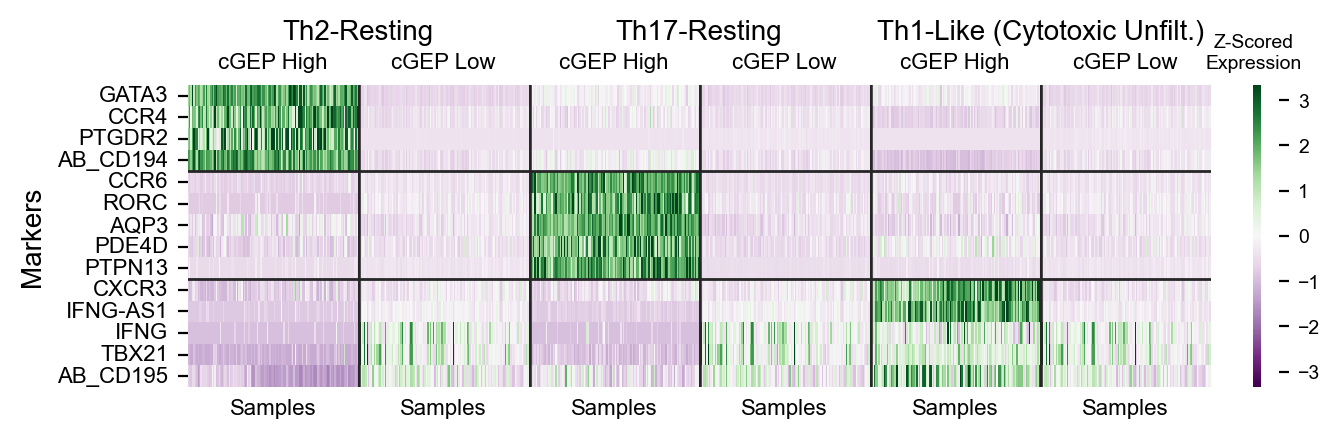

In [159]:
nrows = 1
ncols = 2*len(gep_list)
width = 2.2*len(gep_list)
height = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 200, gridspec_kw = {'wspace' : 0})

for j, g in enumerate(gep_list):
    # High/Low polarizations
    for i, b in enumerate([True, False]):
        ax = axes[2*j + i]
        dat_all = gep_dat[g]
        dat = dat_all[dat_all['Bin_%s' % g]==b]
        dat.index = dat['sample']
        
        sns.heatmap(dat.loc[sample_order, ms_all].T, cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                    ax = ax)
        # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
        ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)
        
        if i == 0:
            if g != 'Th1-Like':
                gname = g
            else:
                gname = 'Th1-Like (Cytotoxic Unfilt.)'
            ax.text(1, 1.15, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)

        ax.set_yticks([])
        ax.set_xticks([])
        # ax.set_xticks(np.arange(0.5, len(ms)), ms)
        ax.tick_params('y', labelsize = tick_fontsize)
        ax.set_xlabel('Samples', fontsize = tick_fontsize)

        if (j==0) & (i==0):
            ax.set_ylabel('Markers', fontsize = label_fontsize)
            ax.set_yticks(np.arange(0.5, len(ms_all)), ms_all)
            # ax.collections[0].colorbar.remove()
            
        elif i==0:
            ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)

        else:
            ax.axvline(0, 0, dat.shape[0], color = '#262626', linewidth = 2)
            
        ax.axhline(4, 0, 10, color = '#262626', linewidth = 1)
        ax.axhline(9, 0, 10, color = '#262626', linewidth = 1)
        

cax = ax.inset_axes([1.1, 0, .3, 1], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
cax.set_xticks([vmin, vmax])
cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
                     '%.1f' % vmax])
cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1)

# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers_AllGenes.Sparks.pdf'), bbox_inches="tight")

## Quantify differential gene expression

In [54]:
from scipy.stats import ttest_rel

In [27]:
sample_order = list(X['sample'].unique())
len(sample_order)

121

In [28]:
X_test = X #X[(X['Cytotoxic'] <= thresh)]

In [30]:
X_test_nocyto = X[(X['Cytotoxic'] <= thresh)]

In [31]:
gep_list = ['Th2-Resting', 'Th17-Resting', 
            'Th1-Like (Cytotoxic Unfilt.)', 'Th1-Like (Cytotoxic Filt.)']

In [32]:
ms_rna_dict = {'Th1-Like' : ['CXCR3','IFNG-AS1', 'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              'Th2-Activated' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Activated' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194']}

In [33]:
gep_list

['Th2-Resting',
 'Th17-Resting',
 'Th1-Like (Cytotoxic Unfilt.)',
 'Th1-Like (Cytotoxic Filt.)']

In [35]:
# Pseudobulk and normalize for each thresholded GEP
# Do not Z-score prior
gep_dat = {}
ms_all = []

for gname in gep_list:
    
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname
        
    if gname=='Th1-Like (Cytotoxic Filt.)':
        sample_sum = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test_nocyto.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']

    else:
        sample_sum = X_test.groupby(['sample', 'Bin_%s' % g]).sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = ms_rna_dict[g]
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
    
    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    # dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    # dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[gname] = dat_all
    ms_all += ms

In [36]:
gep_dat.keys()

dict_keys(['Th2-Resting', 'Th17-Resting', 'Th1-Like (Cytotoxic Unfilt.)', 'Th1-Like (Cytotoxic Filt.)'])

In [74]:
res = pd.DataFrame()

for gname in gep_list:
    if 'Th1-Like' in gname:
        g = 'Th1-Like'
    else:
        g = gname

    ms = []
    ms_rna = ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
        
        
    dat_all = gep_dat[gname]
    dat_high = dat_all[dat_all['Bin_%s' % g]==True]
    dat_high.index = dat_high['sample']
    dat_low = dat_all[dat_all['Bin_%s' % g]==False]
    dat_low.index = dat_low['sample']

    for marker in ms:
        # print(marker)

        t, p = ttest_rel(dat_high.loc[sample_order, marker], 
                  dat_low.loc[sample_order, marker])

        res = res.append(pd.Series([t, p, g, gname, marker],
            index = ['t', 'pval', 'GEP', 'GEP_Name', 'marker']),
              ignore_index = True)

['GATA3', 'CCR4', 'PTGDR2', 'AB_CD194']
['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13']
['CXCR3', 'IFNG-AS1', 'IFNG', 'TBX21', 'AB_CD195']
['CXCR3', 'IFNG-AS1', 'IFNG', 'TBX21', 'AB_CD195']


In [81]:
res['padj'] = res['pval']*res.shape[0]

In [83]:
res[res['padj']>0.05]

,t,pval,GEP,GEP_Name,marker,padj
11,0.370635,0.711563,Th1-Like,Th1-Like (Cytotoxic Unfilt.),IFNG,13.519699
12,2.131095,0.035122,Th1-Like,Th1-Like (Cytotoxic Unfilt.),TBX21,0.667309


In [85]:
res

,t,pval,GEP,GEP_Name,marker,padj
0,42.844709,1.406421e-74,Th2-Resting,Th2-Resting,GATA3,2.672200e-73
1,26.419610,7.604914e-52,Th2-Resting,Th2-Resting,CCR4,1.444934e-50
2,18.657938,2.844847e-37,Th2-Resting,Th2-Resting,PTGDR2,5.405210e-36
3,48.016672,3.419737e-80,Th2-Resting,Th2-Resting,AB_CD194,6.497501e-79
4,47.440498,1.354889e-79,Th17-Resting,Th17-Resting,CCR6,2.574289e-78
5,31.243071,1.759334e-59,Th17-Resting,Th17-Resting,RORC,3.342734e-58
6,47.894153,4.577104e-80,Th17-Resting,Th17-Resting,AQP3,8.696498e-79
7,32.732998,1.176096e-61,Th17-Resting,Th17-Resting,PDE4D,2.234583e-60
8,38.059857,7.931601e-69,Th17-Resting,Th17-Resting,PTPN13,1.507004e-67
9,34.052067,1.621952e-63,Th1-Like,Th1-Like (Cytotoxic Unfilt.),CXCR3,3.081708e-62


In [87]:
res.sort_values('padj')

,t,pval,GEP,GEP_Name,marker,padj
3,48.016672,3.419737e-80,Th2-Resting,Th2-Resting,AB_CD194,6.497501e-79
6,47.894153,4.577104e-80,Th17-Resting,Th17-Resting,AQP3,8.696498e-79
4,47.440498,1.354889e-79,Th17-Resting,Th17-Resting,CCR6,2.574289e-78
0,42.844709,1.406421e-74,Th2-Resting,Th2-Resting,GATA3,2.672200e-73
8,38.059857,7.931601e-69,Th17-Resting,Th17-Resting,PTPN13,1.507004e-67
14,34.116098,1.321976e-63,Th1-Like,Th1-Like (Cytotoxic Filt.),CXCR3,2.511754e-62
9,34.052067,1.621952e-63,Th1-Like,Th1-Like (Cytotoxic Unfilt.),CXCR3,3.081708e-62
7,32.732998,1.176096e-61,Th17-Resting,Th17-Resting,PDE4D,2.234583e-60
10,31.348743,1.225823e-59,Th1-Like,Th1-Like (Cytotoxic Unfilt.),IFNG-AS1,2.329063e-58
5,31.243071,1.759334e-59,Th17-Resting,Th17-Resting,RORC,3.342734e-58


In [92]:
for gname in gep_list:
    display(res[res['GEP_Name']==gname].sort_values('padj'))

,t,pval,GEP,GEP_Name,marker,padj
3,48.016672,3.419737e-80,Th2-Resting,Th2-Resting,AB_CD194,6.497501e-79
0,42.844709,1.406421e-74,Th2-Resting,Th2-Resting,GATA3,2.672200e-73
1,26.419610,7.604914e-52,Th2-Resting,Th2-Resting,CCR4,1.444934e-50
2,18.657938,2.844847e-37,Th2-Resting,Th2-Resting,PTGDR2,5.405210e-36


,t,pval,GEP,GEP_Name,marker,padj
6,47.894153,4.577104e-80,Th17-Resting,Th17-Resting,AQP3,8.696498e-79
4,47.440498,1.354889e-79,Th17-Resting,Th17-Resting,CCR6,2.574289e-78
8,38.059857,7.931601e-69,Th17-Resting,Th17-Resting,PTPN13,1.507004e-67
7,32.732998,1.176096e-61,Th17-Resting,Th17-Resting,PDE4D,2.234583e-60
5,31.243071,1.759334e-59,Th17-Resting,Th17-Resting,RORC,3.342734e-58


,t,pval,GEP,GEP_Name,marker,padj
9,34.052067,1.621952e-63,Th1-Like,Th1-Like (Cytotoxic Unfilt.),CXCR3,3.081708e-62
10,31.348743,1.225823e-59,Th1-Like,Th1-Like (Cytotoxic Unfilt.),IFNG-AS1,2.329063e-58
13,19.690400,2.151500e-39,Th1-Like,Th1-Like (Cytotoxic Unfilt.),AB_CD195,4.087850e-38
12,2.131095,3.512155e-02,Th1-Like,Th1-Like (Cytotoxic Unfilt.),TBX21,6.673094e-01
11,0.370635,7.115631e-01,Th1-Like,Th1-Like (Cytotoxic Unfilt.),IFNG,1.351970e+01


,t,pval,GEP,GEP_Name,marker,padj
14,34.116098,1.321976e-63,Th1-Like,Th1-Like (Cytotoxic Filt.),CXCR3,2.511754e-62
15,30.346498,3.923431e-58,Th1-Like,Th1-Like (Cytotoxic Filt.),IFNG-AS1,7.454518e-57
17,24.217895,5.070481e-48,Th1-Like,Th1-Like (Cytotoxic Filt.),TBX21,9.633915e-47
18,19.318596,1.230007e-38,Th1-Like,Th1-Like (Cytotoxic Filt.),AB_CD195,2.337013e-37
16,8.564993,4.317718e-14,Th1-Like,Th1-Like (Cytotoxic Filt.),IFNG,8.203665e-13


# COMBAT

In [13]:
sorted(adata_ADT.var.index)

['AB_B7-H4',
 'AB_CCR3',
 'AB_CCR7',
 'AB_CD10',
 'AB_CD101',
 'AB_CD103',
 'AB_CD106',
 'AB_CD107a',
 'AB_CD112',
 'AB_CD117',
 'AB_CD11a',
 'AB_CD11b-1',
 'AB_CD11c',
 'AB_CD122',
 'AB_CD123',
 'AB_CD124',
 'AB_CD127',
 'AB_CD133-2',
 'AB_CD137',
 'AB_CD137L',
 'AB_CD138-2',
 'AB_CD14-1',
 'AB_CD141',
 'AB_CD144',
 'AB_CD146',
 'AB_CD15',
 'AB_CD150',
 'AB_CD152',
 'AB_CD154',
 'AB_CD155',
 'AB_CD158',
 'AB_CD158b',
 'AB_CD158e1',
 'AB_CD158f',
 'AB_CD16',
 'AB_CD161',
 'AB_CD163',
 'AB_CD169',
 'AB_CD178',
 'AB_CD18',
 'AB_CD184',
 'AB_CD185',
 'AB_CD19',
 'AB_CD194',
 'AB_CD195',
 'AB_CD196',
 'AB_CD1a',
 'AB_CD1c',
 'AB_CD1d',
 'AB_CD2',
 'AB_CD20',
 'AB_CD204',
 'AB_CD206',
 'AB_CD207',
 'AB_CD209',
 'AB_CD21',
 'AB_CD22',
 'AB_CD223',
 'AB_CD224',
 'AB_CD226-2',
 'AB_CD23',
 'AB_CD235ab',
 'AB_CD24',
 'AB_CD244',
 'AB_CD25',
 'AB_CD252',
 'AB_CD254',
 'AB_CD257',
 'AB_CD258',
 'AB_CD26',
 'AB_CD267',
 'AB_CD268',
 'AB_CD269',
 'AB_CD27-1',
 'AB_CD272',
 'AB_CD273',
 'AB_CD274',


In [42]:
marker_adts = [
            # Polarizations
            'AB_CD194', 'AB_CD195', 'AB_CD4-2', 'AB_CD8',
              
            # Cytotoxic
            'AB_CD25', 'AB_CD39', 'AB_CD45RA', 'AB_CD45RO'
              ]

In [43]:
marker_genes = ['AQP3',
 'CCR4',
 'CCR6',
 'CTLA4',
 'CXCR3',
 'FCGR3A',
 'FOXP3',
 'GATA3',
 'GNLY',
 'GZMB',
 'GZMH',
 'GZMK',
 'IFNG',
 'IL2RA',
 'KLRF1',
 'NCR1',
 'PDE4D',
 'PRF1',
 'PTGDR2',
 'PTPN13',
 'RORC',
 'TBX21']

In [45]:
geps = ['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22', 'Th2-Activated', 'Th17-Activated', 
                    'Cytotoxic', 'CD8-EM', 'TEMRA']

In [46]:
summary = []
for dataset in ['COMBAT']: #, 'Sparks', 'UK-Covid', ' AMP-RA']:
    usage = pd.read_csv(params.loc[dataset, 'tcat_fn'], index_col = 0, sep = '\t')
    usage.columns = usage.columns.map(rename_map)
    usage_norm = usage.div(usage.sum(axis=1), axis=0)
    X = usage_norm[geps]
    X['Dataset'] = dataset
    gating = pd.read_csv(params.loc[dataset, 'manual_gating_fn'], sep='\t', index_col=0)['0']
    X['gating'] = gating.loc[X.index]
    expr_fn = params.loc[dataset, 'raw_counts_filt_fn']
    adata = sc.read(expr_fn)
    adata_RNA = adata[:, adata.var['feature_types'] == 'Gene Expression']
    adata_ADT = adata[:, adata.var['feature_types'] == 'Antibody Capture']
    # meta = pd.read_csv(params.loc[dataset, 'metadata_fn'], index_col = 0, sep = '\t')

    ind = sorted(set(X.index).intersection(adata.obs.index))
    X = X.loc[ind, :]

    X['individual'] = adata_RNA.obs.loc[X.index, params.loc[dataset, 'individual_col']]
    # X['sample'] = meta.loc[X.index, params.loc[dataset, 'sample_col']]
    X['sample'] = adata.obs.loc[X.index, params.loc[dataset, 'sample_col']]    
    X['N'] = np.array(adata_RNA[X.index, :].X.sum(axis=1)).reshape(-1)

    marker_genes_filt = sorted(set(marker_genes).intersection(adata_RNA.var.index))
    print(sorted(set(marker_genes).difference(adata_RNA.var.index)))
    X[marker_genes_filt] = adata_RNA[ind, marker_genes_filt].X.todense()

    X['N_ADT'] = np.array(adata_ADT[X.index, :].X.sum(axis=1)).reshape(-1)
    marker_adts_filt = sorted(set(marker_adts).intersection(adata_ADT.var.index))
    print(sorted(set(marker_adts_filt).difference(adata_ADT.var.index)))
    X[marker_adts_filt] = adata_ADT[ind, marker_adts_filt].X.todense()

/tmp/ipykernel_145678/2559413674.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Dataset'] = dataset


Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].
Only considering the two last: ['.ADTfixed20230831FiltForcNMF', '.h5ad'].


/tmp/ipykernel_145678/2559413674.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['gating'] = gating.loc[X.index]


[]
[]


In [47]:
thresh = 0.1#0.0625

for g in geps:
    X['Bin_%s' % g] = X[g]>thresh

In [48]:
cd4_gates = ['CD4_Naive', 'Treg', 'CD4_EM', 'CD4_CM', 'CD4_TEMRA']
cd8_gates = ['CD8_Naive', 'CD8_EM', 'CD8_CM', 'CD8_TEMRA']

X['class'] = 'Other'
X.loc[X['gating'].isin(cd4_gates), 'class'] = 'CD4'
X.loc[X['gating'].isin(cd8_gates), 'class'] = 'CD8'

## Genes per cGEP

### CD4/CD8 only + split, exclude cytotoxic only for Th1, with CD4/CD8 panel

In [514]:
sample_order = list(X['sample'].unique())
len(sample_order)

138

In [49]:
ms_rna_dict = {'Th1-Like' : ['CXCR3',#'IFNG-AS1',
                             'IFNG', 'TBX21'],
              'Th2-Resting' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Resting' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              'Th2-Activated' : ['GATA3', 'CCR4', 'PTGDR2',],
              'Th17-Activated' : ['CCR6', 'RORC', 'AQP3', 'PDE4D', 'PTPN13'],
              }

ms_adt_dict = {'Th1-Like' : [ 'AB_CD195',],
              'Th2-Resting' : ['AB_CD194'],
              'Th2-Activated' : ['AB_CD194']}

In [50]:
gep_list = ['Th2-Resting',
 'Th17-Resting',
 'Th1-Like']

In [51]:
X_test = X[(X['class'].isin(['CD4', 'CD8']))]
X_test_nocyto = X[(X['class'].isin(['CD4', 'CD8'])) & (X['Cytotoxic'] <= thresh)]

In [520]:
X_test['class'].value_counts()

CD4    267981
CD8    105053
Name: class, dtype: int64

In [53]:
X_test.groupby(['sample', 'class', 'Bin_%s' % g])

/tmp/ipykernel_145678/978459445.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  X_test.groupby(['sample', 'class', 'Bin_%s' % g])


In [54]:
X_test.columns

Index(['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22',
       'Th2-Activated', 'Th17-Activated', 'Cytotoxic', 'CD8-EM', 'TEMRA',
       'Dataset', 'gating', 'individual', 'sample', 'N', 'AQP3', 'CCR4',
       'CCR6', 'CTLA4', 'CXCR3', 'FCGR3A', 'FOXP3', 'GATA3', 'GNLY', 'GZMB',
       'GZMH', 'GZMK', 'IFNG', 'IL2RA', 'KLRF1', 'NCR1', 'PDE4D', 'PRF1',
       'PTGDR2', 'PTPN13', 'RORC', 'TBX21', 'N_ADT', 'AB_CD194', 'AB_CD195',
       'AB_CD25', 'AB_CD39', 'AB_CD4-2', 'AB_CD45RA', 'AB_CD45RO', 'AB_CD8',
       'Bin_Th1-Like', 'Bin_Treg', 'Bin_Th2-Resting', 'Bin_Th17-Resting',
       'Bin_Th22', 'Bin_Th2-Activated', 'Bin_Th17-Activated', 'Bin_Cytotoxic',
       'Bin_CD8-EM', 'Bin_TEMRA', 'class'],
      dtype='object')

In [56]:
[X_test.select_dtypes(include='number').columns]


Index(['Th1-Like', 'Treg', 'Th2-Resting', 'Th17-Resting', 'Th22',
       'Th2-Activated', 'Th17-Activated', 'Cytotoxic', 'CD8-EM', 'TEMRA', 'N',
       'AQP3', 'CCR4', 'CCR6', 'CTLA4', 'CXCR3', 'FCGR3A', 'FOXP3', 'GATA3',
       'GNLY', 'GZMB', 'GZMH', 'GZMK', 'IFNG', 'IL2RA', 'KLRF1', 'NCR1',
       'PDE4D', 'PRF1', 'PTGDR2', 'PTPN13', 'RORC', 'TBX21', 'N_ADT',
       'AB_CD194', 'AB_CD195', 'AB_CD25', 'AB_CD39', 'AB_CD4-2', 'AB_CD45RA',
       'AB_CD45RO', 'AB_CD8'],
      dtype='object')

In [57]:
# Pseudobulk and normalize for each thresholded GEP
gep_dat = {}
ms_all = []

for g in gep_list:
    
    if g=='Th1-Like':
        sample_sum = X_test_nocyto.groupby(['sample', 'class', 'Bin_%s' % g]
                                          )[X_test.select_dtypes(include='number').columns].sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test_nocyto.groupby(['sample', 'class', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']

    else:
        sample_sum = X_test.groupby(['sample', 'class', 'Bin_%s' % g]
                                   )[X_test.select_dtypes(include='number').columns].sum().reset_index().dropna()
        sample_sum['Ncell'] = X_test.groupby(['sample', 'class', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
        
    ms = []
    ms_rna = ms_rna_dict[g]
    pseudobulk = sample_sum[ms_rna] #+1
    pseudobulk = pseudobulk.multiply(1e4 / sample_sum['N'], axis=0) #.apply(np.log2)
    sample_sum[ms_rna] = pseudobulk
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        pseudobulk_adt = sample_sum[ms_adt] #+1
        pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
        sample_sum[ms_adt] = pseudobulk_adt
        ms += ms_adt
    
    sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

    dat_all = sample_sum.copy()
    dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
    dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

    gep_dat[g] = dat_all
    ms_all += ms

/tmp/ipykernel_145678/3194008675.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sum = X_test.groupby(['sample', 'class', 'Bin_%s' % g]
/tmp/ipykernel_145678/3194008675.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sum['Ncell'] = X_test.groupby(['sample', 'class', 'Bin_%s' % g]).count().reset_index().dropna()['Th1-Like']
/tmp/ipykernel_145678/3194008675.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

In [58]:
# Add normalized data for CD4/CD8 also:

sample_sum = X_test.groupby(['sample', 'class'])[X_test.select_dtypes(include='number').columns].sum().reset_index().dropna()
sample_sum['Ncell'] = X_test.groupby(['sample', 'class']).count().reset_index().dropna()['Th1-Like']

ms = []
ms_adt = ['AB_CD4-2', 'AB_CD8']
pseudobulk_adt = sample_sum[ms_adt] #+1
pseudobulk_adt = pseudobulk_adt.multiply(1e4 / sample_sum['N_ADT'], axis=0) #.apply(np.log2)
sample_sum[ms_adt] = pseudobulk_adt
ms += ms_adt

sample_sum[geps] = sample_sum[geps].div(sample_sum['Ncell'], axis=0)

dat_all = sample_sum.copy()
dat_all[ms] = dat_all[ms].subtract(sample_sum[ms].mean(), axis =1)
dat_all[ms] = dat_all[ms].divide(sample_sum[ms].std(), axis = 1)

gep_dat['CD4_CD8'] = dat_all
ms_all += ms

/tmp/ipykernel_145678/2444636074.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sum = X_test.groupby(['sample', 'class'])[X_test.select_dtypes(include='number').columns].sum().reset_index().dropna()
/tmp/ipykernel_145678/2444636074.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sample_sum['Ncell'] = X_test.groupby(['sample', 'class']).count().reset_index().dropna()['Th1-Like']


In [59]:
vmax_list = []
# Get vmax using normalized dat and markers
for g in gep_list:
    dat_all = gep_dat[g]    
    ms = []
    ms_rna = ms_rna_dict[g]
    ms += ms_rna
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    vmax_list += dat_all[ms].unstack().tolist()


vmax = pd.Series(vmax_list).quantile(.98)
vmin = -vmax

In [524]:
vmax

2.68802924156189

In [61]:
label_fontsize = 10
tick_fontsize = 8

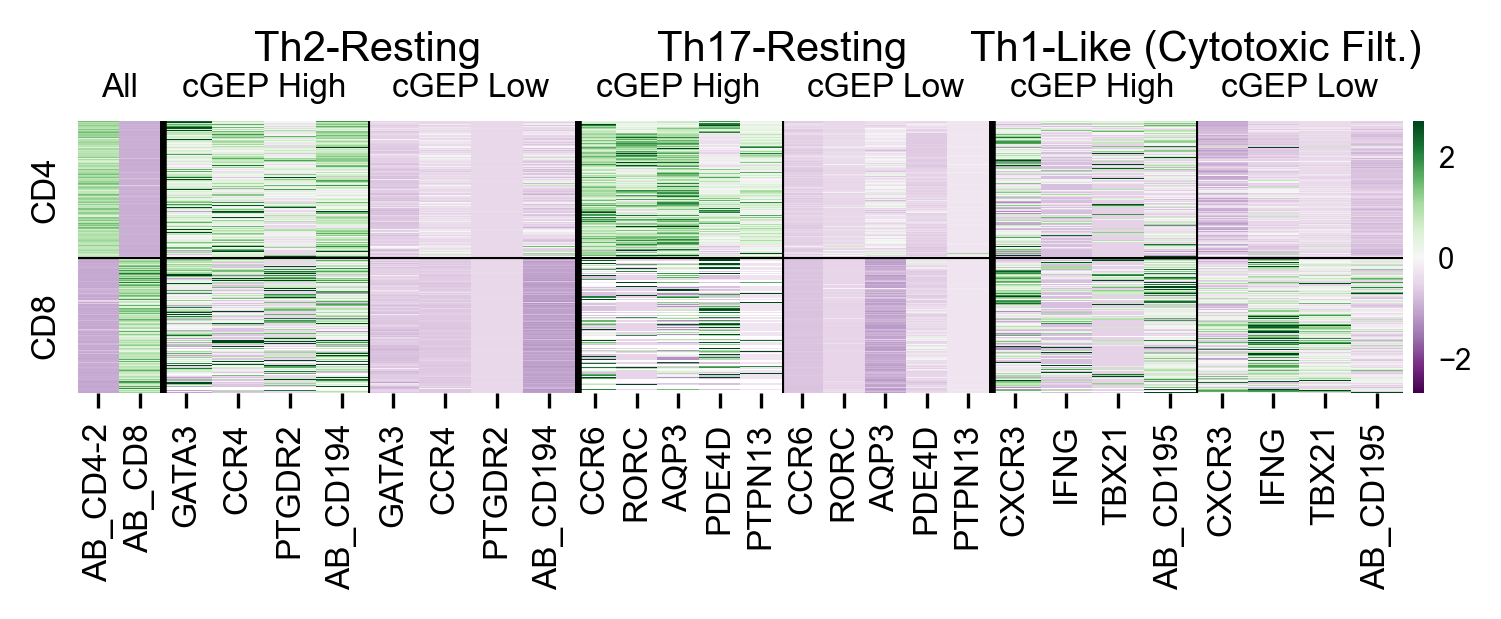

In [546]:
nrows = 2
ncols = 2*len(gep_list) + 1
width = 1.9*len(gep_list)
height = 1.2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (width, height), 
                         dpi = 300, gridspec_kw = {'wspace' : 0, 'hspace' : 0,
                                                  'width_ratios' : [2] + [5]*2*len(gep_list)})

g = 'CD4_CD8'
dat_all = gep_dat[g]
ms = ['AB_CD4-2', 'AB_CD8']
for n, lineage in enumerate(['CD4', 'CD8']):
    ax = axes[n, 0]
    dat = dat_all[(dat_all['class']==lineage)]
    sns.heatmap(dat[ms], cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                ax = ax)
    ax.set_yticks([])
    ax.set_ylabel(lineage, fontsize = tick_fontsize)
    
    if n==0:
        ax.set_xticks([])
        ax.set_title('All', y = 1, fontsize = tick_fontsize)
    
    else:
        ax.set_xticks(np.arange(0.5, len(ms)), ms)
        ax.tick_params('x', labelsize = tick_fontsize, rotation = 90)
        ax.axhline(0, 0, 10, color = 'black', linewidth = 1)
    

for j, g in enumerate(gep_list):
    dat_all = gep_dat[g]
    ms = []
    ms_rna = ms_rna_dict[g]
    ms += ms_rna
    
    if g in ms_adt_dict.keys():
        ms_adt = ms_adt_dict[g]
        ms += ms_adt
    
    for n, lineage in enumerate(['CD4', 'CD8']):
        # High/Low polarizations
        for i, b in enumerate([True, False]):
            ax = axes[n, 2*j + i + 1]   
            dat = dat_all[(dat_all['Bin_%s' % g]==b) & (dat_all['class']==lineage)]
            sns.heatmap(dat[ms], cmap = 'PRGn', vmax = vmax, vmin = vmin, cbar = False,
                        ax = ax)
            # ax.set_title(label_map[b] % g, fontsize = label_fontsize)
            
            if n==0:
                ax.set_title({True: 'cGEP High', False: 'cGEP Low'}[b], y = 1, fontsize = tick_fontsize)

                if i == 0:
                    if g != 'Th1-Like':
                        gname = g
                    else:
                        gname = 'Th1-Like (Cytotoxic Filt.)'

                    ax.text(1, 1.45, s = gname, transform=ax.transAxes, ha = 'center', fontsize = label_fontsize)
                ax.set_xticks([])
                
            else:
                ax.set_xticks(np.arange(0.5, len(ms)), ms)
                ax.axhline(0, 0, 10, color = 'black', linewidth = 1)
                
            ax.set_yticks([])
            ax.tick_params('x', labelsize = tick_fontsize)
            

            # ax.set_ylabel(lineage, fontsize = label_fontsize)
                
            if (i==0):
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 3)

            else:
                ax.axvline(0, 0, dat.shape[0], color = 'black', linewidth = 1)

                
cax = ax.inset_axes([1.05, 0, .05, 2], transform=ax.transAxes)
cbar = fig.colorbar(ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax), 
                            cmap=sns.color_palette("PRGn", as_cmap=True)),
             ax=ax, cax=cax, orientation='vertical')
cbar.outline.set_linewidth(0) 
# cax.set_yticks([])
# cax.set_xticklabels(['%.1f' % vmin , #'%.2f' % vmin, 
#                      '%.1f' % vmax])
# cax.set_title('Z-Scored\nExpression', fontsize = tick_fontsize-1)
cax.tick_params(labelsize=tick_fontsize-1, length=0)


# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.png'), bbox_inches="tight")
# plt.savefig(os.path.join(figdir, 'HeatmapPolarizationMarkers.COMBAT.pdf'), bbox_inches="tight")